In [6]:
from libaries import *
from data_loading import findFiles,LoadDataSignals
from global_parameters import *
from peak_to_peak_detection import *
from Data_Denoising.data_denoising import *
from Data_Denoising.time_synchronization import *
from Data_Denoising.moving_average_filter import *
from Data_Denoising.derivative_filtering import *
from Data_Denoising.derivative_filtering import apply_improved_derivative_filter


#### Extract relevant files for processing


In [7]:
expected_waveform="sin"
expected_periods="9"
unique_file_list= findFiles(expected_waveform,expected_periods,sample_number=1)
unique_file_list

['/Users/madhviasthana/Documents/Bio-Medical-Signal-Processing/dataset/4th_March_1percent/0000mg/25DegreeTemperature4March-ram-WaterSugar_mid_solution-0mg-sin9-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Bio-Medical-Signal-Processing/dataset/4th_March_1percent/51000mg/25DegreeTemperature4March-ram-WaterSugar_mid_solution-51000mg-sin9-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Bio-Medical-Signal-Processing/dataset/4th_March_1percent/187000mg/25DegreeTemperature4March-ram-WaterSugar_mid_solution-187000mg-sin9-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Bio-Medical-Signal-Processing/dataset/4th_March_1percent/153000mg/25DegreeTemperature4March-ram-WaterSugar_mid_solution-153000mg-sin9-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Bio-Medical-Signal-Processing/dataset/4th_March_1percent/85000mg/25DegreeTemperature4March-ram-WaterSugar_mid_solution-85000mg-sin9-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Bio

#### Data Loading

In [8]:
raw,Concentration,actual_waveform,periods=LoadDataSignals(unique_file_list[2],time_axis_start=0,time_axis_end=16000)
raw.shape



(100, 2, 16000)

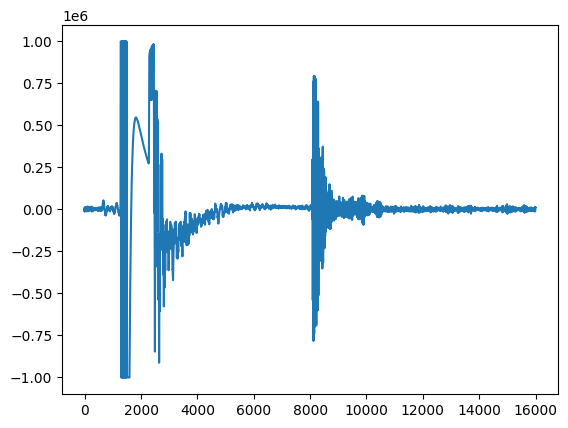

In [9]:
plt.plot(np.arange(0,16000),raw[0,1,:])

#### Time Synchronized Averaging (Experiments=100)

In [10]:
averaged_signal=time_synchronized_averaging(raw,threshold=500000)

DC Offset Remval (100, 2, 16000)
Raw After Null Experiments Removal:  (40, 2, 16000)


In [11]:
averaged_signal.shape

(16000,)

#### Moving Average

In [12]:
# Apply the Hanning filter from the slide
filtered_hanning = apply_hanning_filter(raw, trial_idx=0)

In [13]:
# Print shape to verify
print("Hanning filter (slide) shape:", filtered_hanning.shape) 

Hanning filter (slide) shape: (1, 16000)


In [14]:
filtered_uniform_moving_avg=apply_uniform_moving_average_filter(raw, trial_idx=0, window_size=11)

In [15]:
filtered_uniform_moving_avg.shape

(1, 16000)

In [16]:
filtered_derivative=apply_improved_derivative_filter(raw, channel=1, T=1.0)
#filtered_derivative=apply_uniform_moving_average_filter(filtered_derivative, trial_idx=0, window_size=11)

In [17]:
filtered_derivative.shape

(100, 2, 16000)

#### Weiner filter

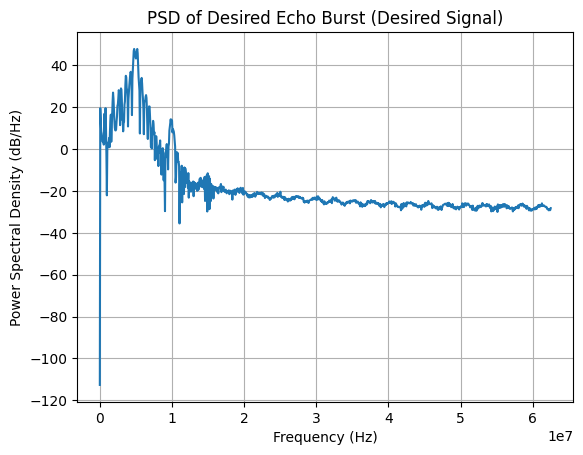

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram

fs = 125_000_000  # Sampling frequency in Hz
signal = averaged_signal

# Select only the echo burst (6000 to 9000 samples)
desired_signal = signal[7000:9000]

# Remove DC offset
desired_signal = desired_signal - np.mean(desired_signal)

# Choose nfft
L = len(desired_signal)
nfft = max(256, 2**int(np.ceil(np.log2(L))))

# Compute PSD
f, Pxx = periodogram(desired_signal, fs=fs, nfft=nfft)

# Plot PSD
plt.figure()
plt.plot(f, 10 * np.log10(Pxx))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (dB/Hz)")
plt.title("PSD of Desired Echo Burst (Desired Signal)")
plt.grid(True)
plt.show()


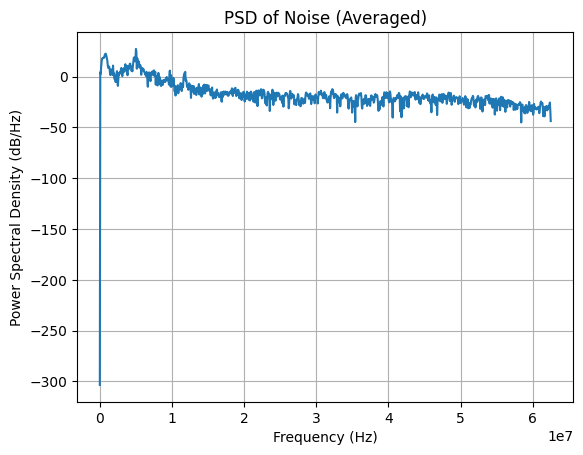

In [19]:
# Example raw_signal = one of your unaveraged CMUT signals

# Choose noise-only segments
noise1 = raw[0,1,0:1000]         # Before burst
noise2 = raw[0,1,10000:16000]    # After ripples

# Remove DC component
noise1 = noise1.astype(float)
noise2 = noise2.astype(float)

noise1 -= np.mean(noise1)
noise2 -= np.mean(noise2)

# Compute PSDs
f, Pxx1 = periodogram(noise1, fs=fs, nfft=nfft)
_, Pxx2 = periodogram(noise2, fs=fs, nfft=nfft)

# Average the PSDs to estimate noise PSD
Pxx_noise_avg = (Pxx1 + Pxx2) / 2

# Plot
plt.figure()
plt.plot(f, 10 * np.log10(Pxx_noise_avg))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (dB/Hz)")
plt.title("PSD of Noise (Averaged)")
plt.grid(True)
plt.show()


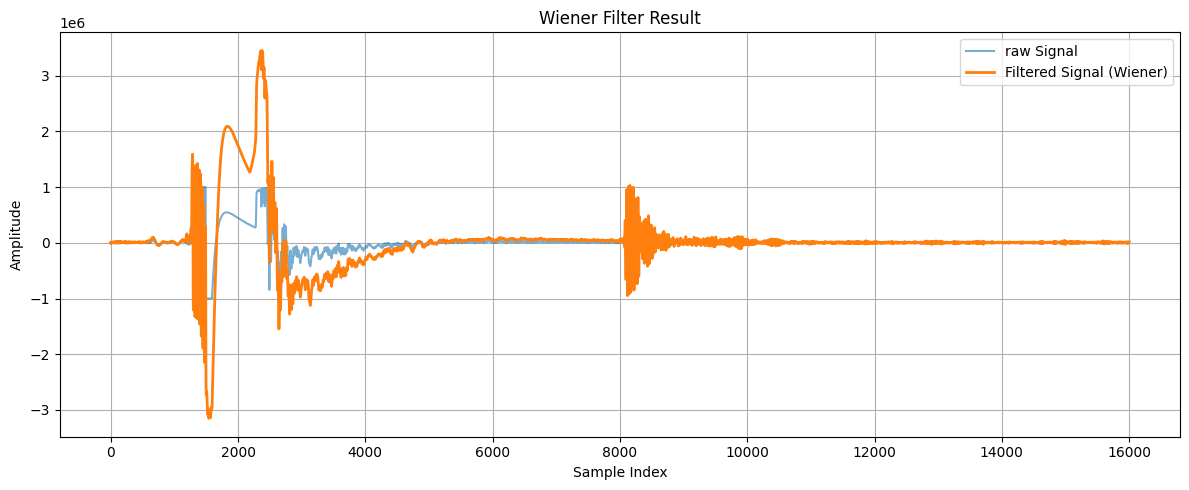

In [20]:
from scipy.fft import ifft, fftshift
from scipy.signal import convolve

# Compute Wiener filter transfer function
H = 1 / (1 + (Pxx_noise_avg / (Pxx + 1e-12)))  # avoid division by zero

# Inverse FFT to get filter in time domain
# Optional: use fftshift to match MATLAB's ifftshift logic
h_time = np.abs(fftshift(ifft(H, n=200)))  # Take only 200 points like in the lecture

# Apply the Wiener filter to the noisy signal using convolution
noisy_signal = raw[0, 1, :].astype(float)
filtered_signal = convolve(noisy_signal, h_time, mode='same')  # 'same' keeps original length

# Plot comparison
plt.figure(figsize=(12, 5))
#plt.plot(noisy_signal, label='Noisy Signal', alpha=0.6)
plt.plot(raw[0,1,:], label='raw Signal', alpha=0.6)

plt.plot(filtered_signal, label='Filtered Signal (Wiener)', linewidth=2)
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.title("Wiener Filter Result")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Data Plotting (For Testing)

In [21]:
"""buffer = 50
for i in range(raw.shape[0]):
    current_ref_point = reference_points[i]
    if  current_ref_point != 0 :
        time_range=np.arange(current_ref_point - buffer,current_ref_point + buffer)
        plt.plot(time_range,raw[i,1,current_ref_point - buffer:current_ref_point + buffer])
        plt.scatter(current_ref_point , raw[i,1,current_ref_point])
        plt.show()
        """

'buffer = 50\nfor i in range(raw.shape[0]):\n    current_ref_point = reference_points[i]\n    if  current_ref_point != 0 :\n        time_range=np.arange(current_ref_point - buffer,current_ref_point + buffer)\n        plt.plot(time_range,raw[i,1,current_ref_point - buffer:current_ref_point + buffer])\n        plt.scatter(current_ref_point , raw[i,1,current_ref_point])\n        plt.show()\n        '

In [22]:
start=6000
end=6100

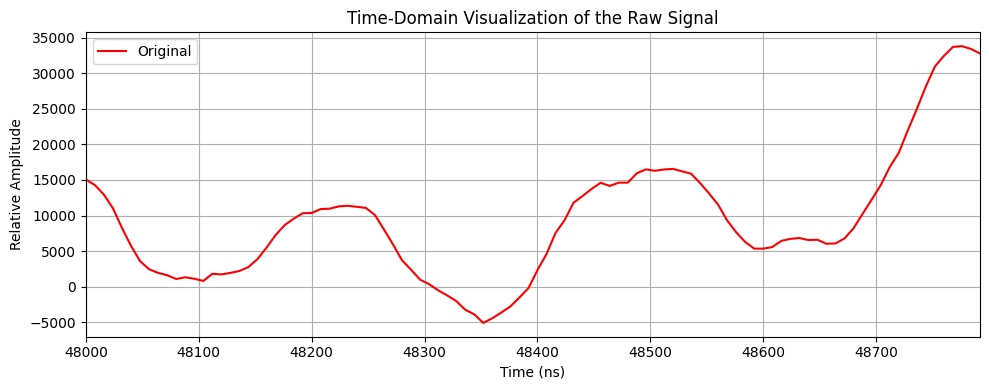

In [23]:
Fs = 125e6  # 125 MHz
Ts_ns = 1e9 / Fs  # Sampling period in nanoseconds

time_ns = np.arange(start, end) * Ts_ns

plt.figure(figsize=(10, 4))
plt.plot(time_ns, raw[0,1,start:end], label='Original', color='red')
plt.title('Time-Domain Visualization of the Raw Signal')
plt.xlabel('Time (ns)')
plt.ylabel('Relative Amplitude')
plt.legend()
plt.grid(True)
plt.xlim(time_ns[0], time_ns[-1])

plt.tight_layout()
plt.show()


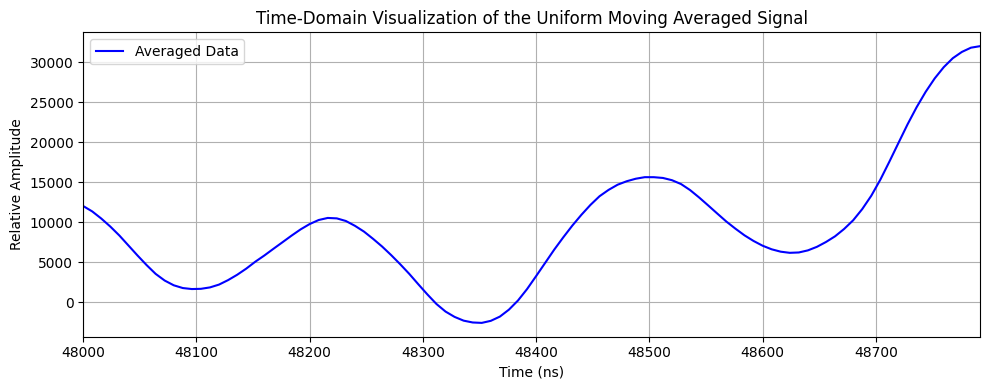

In [24]:
Fs = 125e6  # 125 MHz
Ts_ns = 1e9 / Fs  # Sampling period in nanoseconds

time_ns = np.arange(start, end) * Ts_ns

plt.figure(figsize=(10, 4))
plt.plot(time_ns, filtered_uniform_moving_avg[0][start:end], label='Averaged Data', color='blue')
plt.title('Time-Domain Visualization of the Uniform Moving Averaged Signal')
plt.xlabel('Time (ns)')
plt.ylabel('Relative Amplitude')
plt.legend()
plt.grid(True)
plt.xlim(time_ns[0], time_ns[-1])

plt.tight_layout()
plt.show()



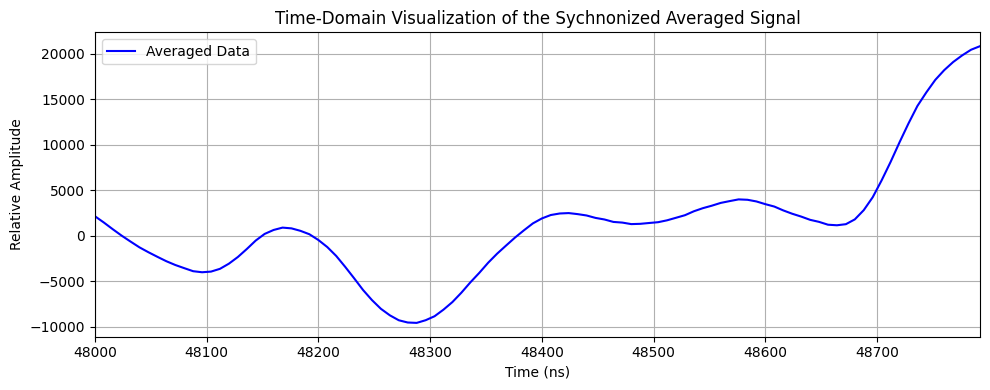

In [25]:
Fs = 125e6  # 125 MHz
Ts_ns = 1e9 / Fs  # Sampling period in nanoseconds

time_ns = np.arange(start, end) * Ts_ns

plt.figure(figsize=(10, 4))
plt.plot(time_ns, averaged_signal[start:end], label='Averaged Data', color='blue')
plt.title('Time-Domain Visualization of the Sychnonized Averaged Signal')
plt.xlabel('Time (ns)')
plt.ylabel('Relative Amplitude')
plt.legend()
plt.grid(True)
plt.xlim(time_ns[0], time_ns[-1])

plt.tight_layout()
plt.show()



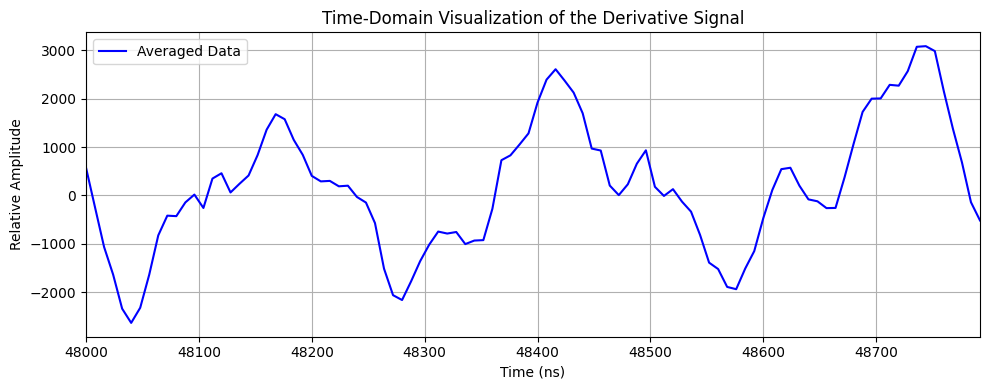

In [26]:
Fs = 125e6  # 125 MHz
Ts_ns = 1e9 / Fs  # Sampling period in nanoseconds

time_ns = np.arange(start, end) * Ts_ns

plt.figure(figsize=(10, 4))
plt.plot(time_ns, filtered_derivative[0,1,start:end], label='Averaged Data', color='blue')
plt.title('Time-Domain Visualization of the Derivative Signal')
plt.xlabel('Time (ns)')
plt.ylabel('Relative Amplitude')
plt.legend()
plt.grid(True)
plt.xlim(time_ns[0], time_ns[-1])

plt.tight_layout()
plt.show()



In [27]:
averaged_signal

array([-10525.05  , -23739.455 ,  -3387.5767, ...,   4510.299 ,
         4107.073 ,   3196.3977], shape=(16000,), dtype=float32)

Noise region shape: (4000,)
Noise region min/max: -33678.71 17951.373
Noise region std dev: 6457.864


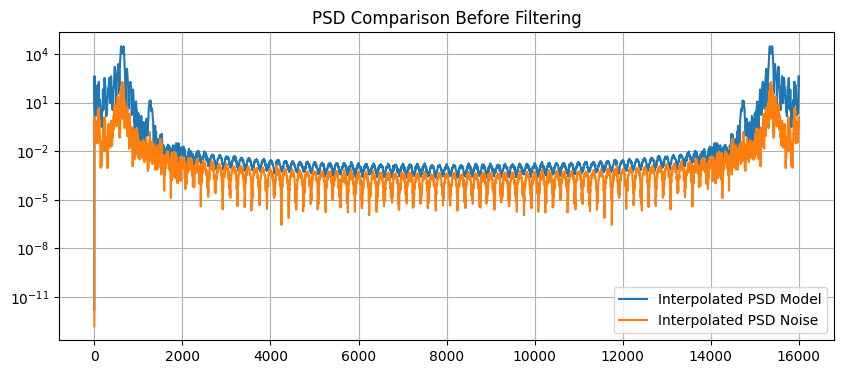

In [28]:
# Re-import after code execution state reset
import numpy as np
from scipy.fft import fft, ifft
from scipy.signal import periodogram, resample


def apply_nptel_style_wiener_filter(   signal=averaged_signal,
    model_region=averaged_signal[5000:9000] ,
    noise_region=averaged_signal[12000:16000], fs=125_000_000, nfft=4096):
    """
    Apply NPTEL-style Wiener filter using PSD of model vs noise.

    Parameters:
        signal (np.ndarray): 1D noisy signal (e.g., averaged signal).
        model_region (np.ndarray): A region from signal or synthetic model to define 'clean signal' PSD.
        noise_region (np.ndarray): A region from signal assumed to be noise only.
        fs (int): Sampling frequency.
        nfft (int): FFT size for PSD estimation.

    Returns:
        np.ndarray: Wiener-filtered signal.
    """

    print("Noise region shape:", noise_region.shape)
    print("Noise region min/max:", np.min(noise_region), np.max(noise_region))
    print("Noise region std dev:", np.std(noise_region))


    f_model, psd_model = periodogram(model_region, fs=fs, nfft=nfft)
    if np.std(noise_region) < 1e-10:
        raise ValueError("Noise region appears to be constant or too flat. Please select a better noise window.")
    f_noise, psd_noise = periodogram(noise_region - np.mean(noise_region), fs=fs, nfft=nfft)

    freq_full = np.fft.fftfreq(len(signal), d=1/fs)
    abs_freq_full = np.abs(freq_full)
    psd_model_interp = np.interp(abs_freq_full, f_model, psd_model)
    psd_noise_interp = np.interp(abs_freq_full, f_noise, psd_noise)

    eps = 1e-10
    H = 1 / (1 + psd_noise_interp / (psd_model_interp + eps))

    signal_fft = fft(signal)
    filtered_fft = H * signal_fft
    filtered_signal = ifft(filtered_fft).real

    import matplotlib.pyplot as plt

    plt.figure(figsize=(10,4))
    plt.plot(psd_model_interp, label="Interpolated PSD Model")
    plt.plot(psd_noise_interp, label="Interpolated PSD Noise")
    plt.yscale("log")
    plt.title("PSD Comparison Before Filtering")
    plt.legend()
    plt.grid(True)
    plt.show()




    return filtered_signal


# Suppose `averaged_signal` is your [16000,] signal
# Noise-only region (from tail end)
model_region = averaged_signal[5000:9000]  # this should capture the first echo burst
noise_region = averaged_signal[12000:16000]

# Apply filtering
filtered_signal = apply_nptel_style_wiener_filter(
    signal=averaged_signal,
    model_region=averaged_signal[5000:9000] ,
    noise_region=averaged_signal[12000:16000]
)




In [29]:
signal.shape

(16000,)

In [30]:
filtered_signal.shape

(16000,)

signal:  (16000,)
shape of average signal time synchronized (16000,) and raw signal (16000,) and for moving average (1, 16000)
shape of average signal time synchronized [-10525.05   -23739.455   -3387.5767 ...   4510.299    4107.073
   3196.3977] and raw signal [-1014.23 -6299.99  1840.76 ...  4999.91  4838.62  4474.35] and for moving average [[ -352.18181818 -1475.72727273 -1815.81818182 ...  8539.90909091
   7982.36363636  7155.18181818]]


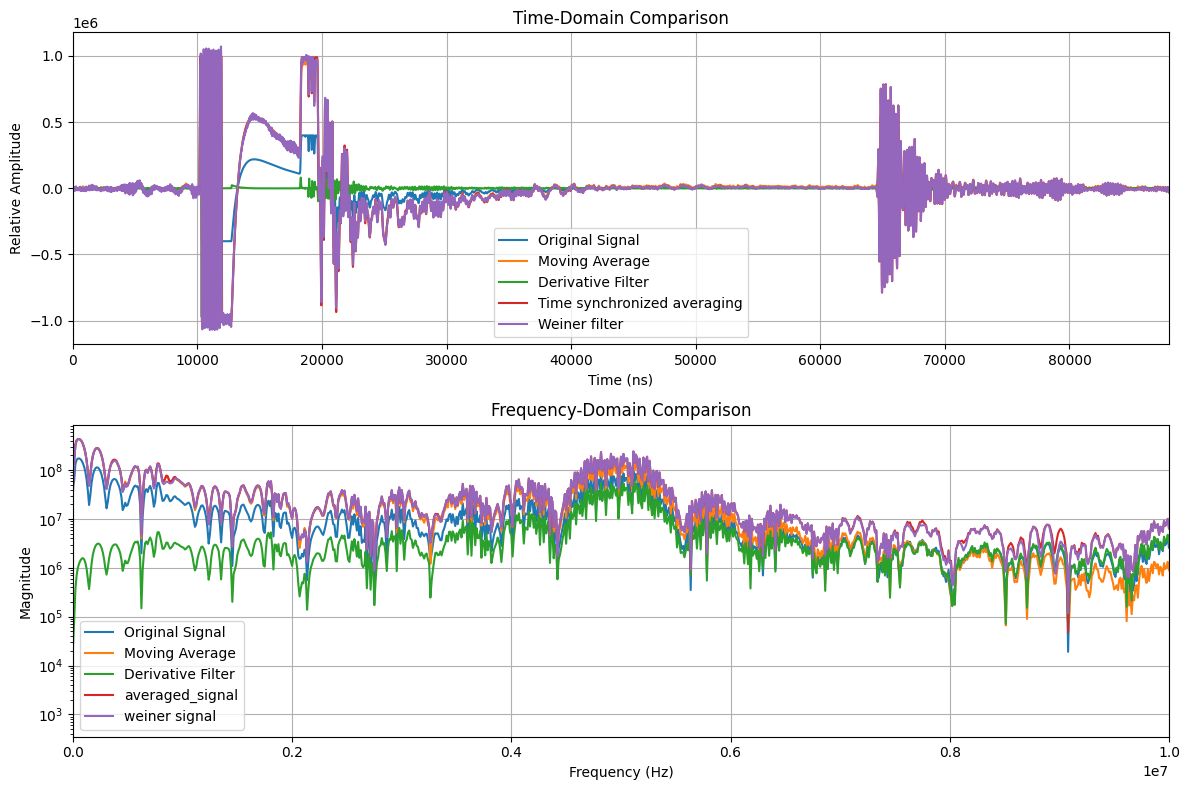

[5.68181818e+04 2.15909091e+05 3.75000000e+05 4.77272727e+05
 5.68181818e+05 5.90909091e+05 6.70454545e+05 7.04545455e+05
 7.72727273e+05 8.52272727e+05 9.31818182e+05 1.05681818e+06
 1.18181818e+06 1.29545455e+06 1.38636364e+06 1.55681818e+06
 1.68181818e+06 1.78409091e+06 1.80681818e+06 1.84090909e+06
 1.87500000e+06 1.93181818e+06 1.96590909e+06 2.02272727e+06
 2.09090909e+06 2.11363636e+06 2.22727273e+06 2.35227273e+06
 2.45454545e+06 2.47727273e+06 2.54545455e+06 2.56818182e+06
 2.60227273e+06 2.62500000e+06 2.64772727e+06 2.67045455e+06
 2.70454545e+06 2.72727273e+06 2.81818182e+06 2.88636364e+06
 2.90909091e+06 2.93181818e+06 2.97727273e+06 3.00000000e+06
 3.06818182e+06 3.12500000e+06 3.18181818e+06 3.22727273e+06
 3.30681818e+06 3.32954545e+06 3.40909091e+06 3.44318182e+06
 3.46590909e+06 3.50000000e+06 3.53409091e+06 3.55681818e+06
 3.59090909e+06 3.62500000e+06 3.64772727e+06 3.68181818e+06
 3.71590909e+06 3.73863636e+06 3.77272727e+06 3.79545455e+06
 3.87500000e+06 3.954545

In [31]:
start=0
end=11000
# Extract the original signal for channel 2 and average across trials
signal = np.mean(raw[:, 1, :], axis=0)  # Shape: [16000], averaged over 100 trials
print("signal: ", signal.shape)

# Time axis (64000 to 65400 ns, matching your plot)
time = np.arange(start, end)* Ts_ns  # Length: 1401

print(f"shape of average signal time synchronized {averaged_signal.shape} and raw signal {signal.shape} and for moving average {filtered_uniform_moving_avg.shape}")
print(f"shape of average signal time synchronized {averaged_signal} and raw signal {signal} and for moving average {filtered_uniform_moving_avg}")


# Slice the signal and filtered data to match the time range (1401 samples)
signal = signal[start:end]  # Shape: [1401]
ma_filtered = filtered_uniform_moving_avg[0, start:end]  # Shape: [1401], from [1, 16000]
deriv_filtered = filtered_derivative[0,1, start:end]  # Shape: [1401], assuming [1, 16000]
averaged_signal = averaged_signal[start:end]
filtered_signal=filtered_signal[start:end]


# Compute FFT and frequency axis
n_samples = len(signal)  # 1401 samples
sampling_rate =125e6  # 125 MHz

freq_axis = fftfreq(n_samples, d=1/sampling_rate)[:n_samples//2]
signal_fft = np.abs(fft(signal))[:n_samples//2]
ma_fft = np.abs(fft(ma_filtered))[:n_samples//2]
deriv_fft = np.abs(fft(deriv_filtered))[:n_samples//2]
averaged_fft = np.abs(fft(averaged_signal))[:n_samples//2]
weiner_fft=np.abs(fft(filtered_signal))[:n_samples//2]

# Plot time-domain comparison
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(time, signal, label="Original Signal")
plt.plot(time, ma_filtered, label="Moving Average")
plt.plot(time, deriv_filtered, label="Derivative Filter")
plt.plot(time, averaged_signal, label="Time synchronized averaging")
plt.plot(time, filtered_signal, label="Weiner filter")
plt.xlim(time[0], time[-1])

plt.title("Time-Domain Comparison")
plt.xlabel("Time (ns)")
plt.ylabel("Relative Amplitude")

plt.legend()
plt.grid()

# Plot frequency-domain comparison
plt.subplot(2, 1, 2)
plt.plot(freq_axis, signal_fft, label="Original Signal")
plt.plot(freq_axis, ma_fft, label="Moving Average")
plt.plot(freq_axis, deriv_fft, label="Derivative Filter")
plt.plot(freq_axis, averaged_fft, label="averaged_signal")
plt.plot(freq_axis, weiner_fft, label="weiner signal")

plt.xlim(0, 10e6)
#plt.xlim(0, 200)  # Zoom into 0–200 Hz

plt.yscale('log')

plt.title("Frequency-Domain Comparison")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

from scipy.signal import find_peaks
peaks, _ = find_peaks(averaged_fft, height=50000)
print(freq_axis[peaks])


#### Statistical testing

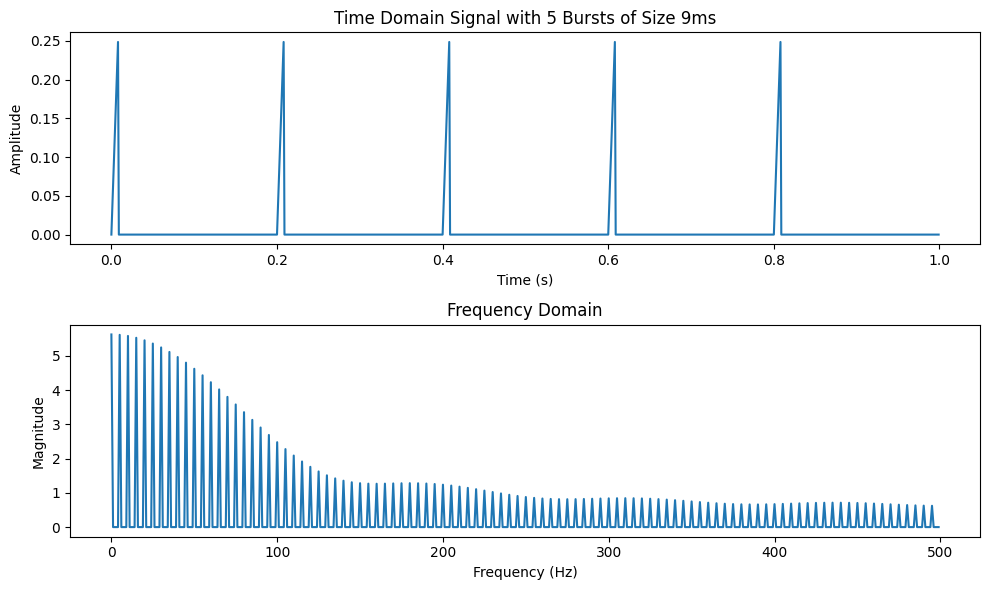

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 1000  # Sampling frequency (Hz)
duration = 1  # Total duration of the signal in seconds
frequency = 5  # Frequency of the sine wave in Hz
bursts = 5  # Number of bursts
burst_size = 9  # Size of each burst (number of samples)

# Time vector
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Create a sine wave
signal = np.zeros_like(t)

# Define burst duration in samples
burst_duration = int(burst_size * fs / 1000)  # Convert burst size to samples (ms to samples)

for i in range(bursts):
    # Start and end time for each burst
    start = int(i * len(t) / bursts)
    end = start + burst_duration
    
    # Apply sine wave to the burst segment
    signal[start:end] = np.sin(2 * np.pi * frequency * t[start:end])

# Plot the signal in the time domain
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, signal)
plt.title(f'Time Domain Signal with {bursts} Bursts of Size {burst_size}ms')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot the signal in the frequency domain
fft_signal = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(fft_signal), 1/fs)
positive_frequencies = frequencies[:len(frequencies)//2]
fft_signal_mag = np.abs(fft_signal)[:len(frequencies)//2]

plt.subplot(2, 1, 2)
plt.plot(positive_frequencies, fft_signal_mag)
plt.title('Frequency Domain')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()


In [33]:
def design_highpass_filter(cutoff_hz, fs_hz, order=2):
    nyquist = fs_hz / 2
    normalized_cutoff = cutoff_hz / nyquist
    sos = butter(order, normalized_cutoff, btype='highpass', output='sos')
    return sos


In [ ]:

fs = 125e6         # 125 MHz
cutoff = 1e6       # 1 MHz
sos = design_highpass_filter(cutoff, fs)

filtered_data = sosfilt(sos, raw)


In [49]:
filtered_data.shape

(100, 2, 16000)